# Explaining RandomForestRegressor Trained on Bostong Housing Using URegressionExplainer.

This is simple example of how to explain predictions for Boston housing

## Fit  RandomForestRegressor

In [1]:
from ibreakdown import URegressionExplainer
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)

In [2]:
def read_data(seed=None):
    # read dataset and split it into training and test set
    boston = load_boston()
    columns = list(boston.feature_names)
    X, y = boston['data'], boston['target']
    df = pd.DataFrame(data=X, columns=columns)
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.3, random_state=seed
    )
    return X_train, X_test, y_train, y_test, columns


In [3]:
seed = 42  # fix seed for resprodusable results

In [4]:
X_train, X_test, y_train, y_test, columns = read_data(seed=seed)

In [5]:
rf = RandomForestRegressor(random_state=seed)
param_grid = {
    'n_estimators': [300, 200],
    'max_depth': [3],
    'oob_score': [True],
}

gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
)
model = gs.fit(X_train, y_train)

## Lets Explain Prediction From X_test

Fit `URegressionExplainer`

In [6]:
explainer = URegressionExplainer(model.predict)
explainer.fit(X_train, columns)

Pick observation to explain from testing set.

In [7]:
observation = X_train.iloc[0:1]
observation

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21


In [8]:
prediciont = model.predict(observation)

In [9]:
exp = explainer.explain(observation)

### Check Shapley Invariant
Sum of contributions and baseline (intercept) should be equal to predicted value:

In [10]:
predicted_value = prediciont[0]
sum_explanations =  np.sum(exp.contributions[0]) + exp.baseline
f'Predicted {predicted_value} Sum of contributions {sum_explanations}'

'Predicted 24.847671115542724 Sum of contributions 24.84767111554272'

In [11]:
np.allclose(predicted_value, sum_explanations) # values should be very close

True

### Print and Plot Explanations

In [12]:
 exp.print()

+----+----------------+-----------------+----------------+--------------------+
|    | Feature Name   |   Feature Value |   Contribution |   Contribution STD |
|----+----------------+-----------------+----------------+--------------------|
|  0 | CRIM           |         0.02985 |    -0.274687   |         0.287227   |
|  1 | ZN             |         0       |    -0.00162524 |         0.00292686 |
|  2 | INDUS          |         2.18    |    -0.0325121  |         0.0180257  |
|  3 | CHAS           |         0       |    -0.0021584  |         0.00167209 |
|  4 | NOX            |         0.458   |    -0.143453   |         0.104419   |
|  5 | RM             |         6.43    |    -1.91527    |         0.0366325  |
|  6 | AGE            |        58.7     |    -0.0299579  |         0.0185941  |
|  7 | DIS            |         6.0622  |    -0.613139   |         0.317984   |
|  8 | RAD            |         3       |    -0.045313   |         0.0279847  |
|  9 | TAX            |       222       

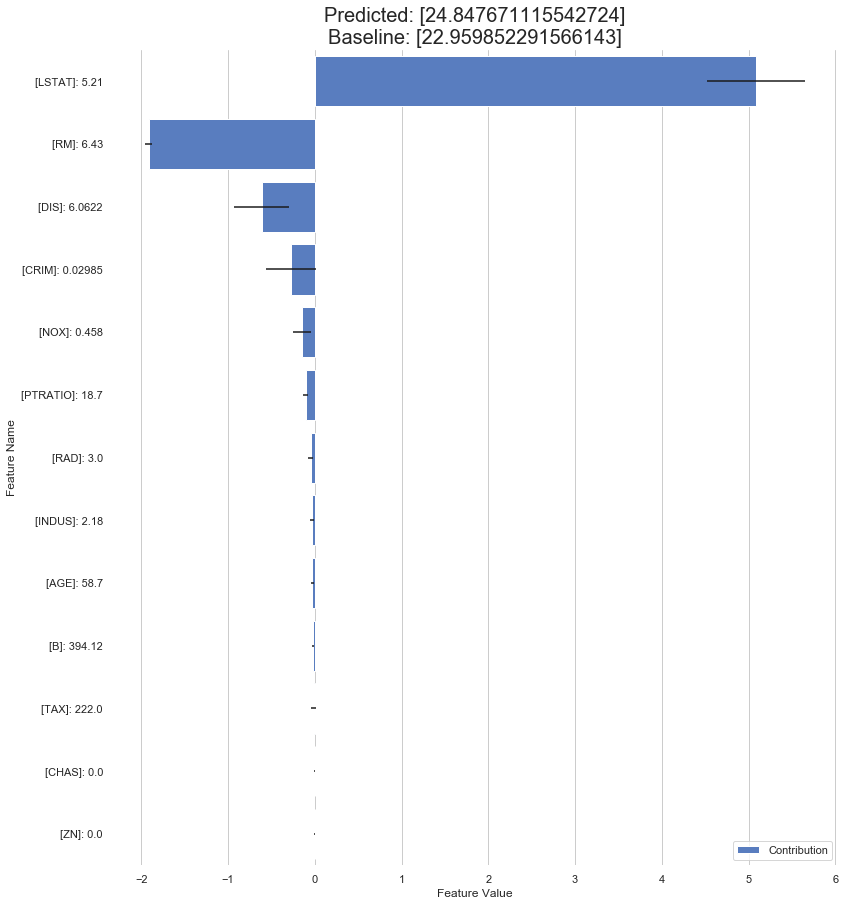

In [13]:
df = exp.plot()